# Загрузка Pandas и очистка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from scipy.stats import ttest_ind
import datetime
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('D:\projects\skillfactory\main_task_new.csv')

In [3]:
df.columns = ['_'.join(col.split()).lower() for col in df.columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Предобработка

In [5]:
# Функция для заполнения dummy переменных.
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Обработаем ранжирование

In [6]:
# Создадим новые признаки по ранжированию по городам - минимум, максимум, нормализованный.
rank_city_min = df.groupby(['city'])['ranking'].min().to_dict()
rank_city_max = df.groupby(['city'])['ranking'].max().to_dict()
df['rank_city_min'] = df.city.map(rank_city_min)
df['rank_city_max'] = df.city.map(rank_city_max)
df['rank_norm'] = df.apply(lambda x: (x['ranking'] - x['rank_city_min'])/(x['rank_city_max'] - x['rank_city_min']), axis=1)

# Обработаем цены

In [7]:
# В столбце Price Range 13886 пустых значений, количество знаков $ указывает на размер цен.
df['price_range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [8]:
# Добавим признак по неизвестным ценам.
df['price_NaN'] = df['price_range'].isna().astype('int32')

In [9]:
# Заменим символьное обозначение цен в колонке Price Range на числовое.
price = {
    '$': 0,
    '$$ - $$$': 1,
    '$$$$': 2
    }

df['price_range'] = df['price_range'].replace(price)

In [10]:
# Пропуски заполним средним значением.
df['price_range'].fillna(1, inplace = True)

# Обработаем количество отзывов

In [11]:
# Создадим признак отсутствия отзыва.
df['number_of_reviews_NaN'] = df['number_of_reviews'].isna().astype('int32')

In [12]:
# Где нет отзывов, заполним пропуски нулем.
df['number_of_reviews'].fillna(0, inplace = True)
df['number_of_reviews'].count()

40000

# Обработаем кухню

In [13]:
# В столбце 9283 пропущенных значений, сделаем новый признак по ним.
df['NaN_cuisine_style'] = pd.isna(df['cuisine_style']).astype('float64') 

In [14]:
# Удалим лишние символы из столбца Cuisine Style, пустые строки заполним неопреденным стилем для проверки.
df['cuisine_style'].fillna('Any', inplace = True)
df['cuisine_style']=df['cuisine_style'].replace('\[','',regex=True)
df['cuisine_style']=df['cuisine_style'].replace('\]','',regex=True)
df['cuisine_style']=df['cuisine_style'].replace('\'','',regex=True)

In [15]:
# Проверим, как часто встречается каждый стиль.
cuisine = df['cuisine_style'].apply(lambda x: [item for elem in [x.split(', ')] for item in elem])
cuisine_list = sum(cuisine, [])
count_cuisine = Counter(cuisine_list).most_common() 
count_cuisine

[('Vegetarian Friendly', 11189),
 ('European', 10060),
 ('Any', 9283),
 ('Mediterranean', 6277),
 ('Italian', 5964),
 ('Vegan Options', 4486),
 ('Gluten Free Options', 4113),
 ('Bar', 3297),
 ('French', 3190),
 ('Asian', 3011),
 ('Pizza', 2849),
 ('Spanish', 2798),
 ('Pub', 2449),
 ('Cafe', 2325),
 ('Fast Food', 1705),
 ('British', 1595),
 ('International', 1584),
 ('Seafood', 1505),
 ('Japanese', 1464),
 ('Central European', 1393),
 ('American', 1315),
 ('Sushi', 1156),
 ('Chinese', 1145),
 ('Portuguese', 1107),
 ('Indian', 1041),
 ('Middle Eastern', 782),
 ('Thai', 743),
 ('Wine Bar', 697),
 ('German', 662),
 ('Healthy', 620),
 ('Greek', 604),
 ('Halal', 598),
 ('Czech', 595),
 ('Fusion', 577),
 ('Steakhouse', 573),
 ('Barbecue', 555),
 ('Contemporary', 523),
 ('Vietnamese', 513),
 ('Eastern European', 496),
 ('Soups', 494),
 ('Grill', 490),
 ('Gastropub', 471),
 ('Mexican', 445),
 ('Turkish', 444),
 ('Delicatessen', 392),
 ('Austrian', 380),
 ('South American', 372),
 ('Polish', 365

In [16]:
# Переименуем проверочный стиль на самый популярный.
df['cuisine_style']=df['cuisine_style'].replace('Any','Vegetarian Friendly', regex=True)

In [17]:
# Сделаем новый признак по количеству указанных кухонь.
df['count_cuisine'] = df['cuisine_style'].apply(lambda x: len(str(x).split(',')))

In [18]:
# Создадим новый признак по вегетарианской/веганской кухням.
def find_item_1(style):
    if 'Vegan Options' in style or 'Vegetarian Friendly' in style:
        return 1
    return 0

df['vegetarian'] = df['cuisine_style'].apply(find_item_1)

In [19]:
# Создадим новый признак по азиатским кухням.

def find_item_2(style):
    if 'Japanese' in style or 'Asian' in style or 'Chinese' in style or 'Sushi' in style or 'Indian' in style or 'Thai' in style\
    or 'Vietnamese' in style or 'Korean' in style or 'Nepali' in style or 'Bangladeshi' in style or 'Indonesian' in style\
    or 'Yunnan' in style or 'Malaysian' in style or 'Sri Lankan' in style or 'Tibetan' in style or 'Taiwanese' in style or 'Cambodian' in style\
    or 'Singaporean' in style or 'Mongolian' in style or 'Xinjiang' in style or 'Burmese' in style or 'Central Asian' in style\
    or 'Filipino' in style or 'Minority Chinese' in style or 'Fujian' in style or 'Burmese' in style: 
        return 1
    return 0

df['asian_cuisine'] = df['cuisine_style'].apply(find_item_2)

# Обработаем города

In [20]:
# Создадим dummy признаки по городам.
city = set(df['city'].tolist())

for item in city:
    df[item] = df['city'].apply(find_item)

In [21]:
#  Добавим признак - столица.
capitals = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon',
        'Vienna', 'Amsterdam', 'Brussels', 'Stockholm', 'Budapest', 'Warsaw',
        'Dublin', 'Copenhagen', 'Athens', 'Oslo', 'Helsinki', 'Bratislava',
        'Luxembourg', 'Ljubljana', 'Edinburgh']

df['capital'] = df['city'].apply(lambda x: 1 if x in capitals else 0)

In [22]:
# Добавим признак - количество ресторанов в городе.
df['numb_of_rest_city'] = df['city'].map(df.groupby(['city'])['restaurant_id'].count().to_dict())

In [23]:
# Добавим признак - население города (деленный на 1000000).
population = {
        'London': 8908081,
        'Paris': 2148327,
        'Madrid': 3221824,
        'Barcelona': 1628552,
        'Berlin': 3644826,
        'Milan': 1372434,
        'Rome': 2864466,
        'Prague': 1301132,
        'Lisbon': 506654,
        'Vienna': 1888776,
        'Amsterdam': 872757,
        'Brussels': 185103,
        'Hamburg': 1841179,
        'Munich': 1471508,
        'Lyon': 506615,
        'Stockholm': 961609,
        'Budapest': 1752286,
        'Warsaw': 1790658,
        'Dublin': 1173179,
        'Copenhagen': 615993,
        'Athens': 664046,
        'Edinburgh': 488100,
        'Zurich': 428737,
        'Oporto': 237591 ,
        'Geneva': 200548,
        'Krakow': 779115,
        'Oslo': 673469,
        'Helsinki': 655281,
        'Bratislava': 437725,
        'Luxembourg': 124509,
        'Ljubljana': 284355
    }

df['population'] = df['city'].replace(population) / 1000000

In [24]:
# Добавим признак плотности населения по городам (деленный на 10000).
population_density = {
        'London': 5667,
        'Paris': 20781,
        'Madrid': 5345,
        'Barcelona': 16285,
        'Berlin': 4463,
        'Milan': 7582,
        'Rome': 2225,
        'Prague': 2506,
        'Lisbon': 6658,
        'Vienna': 4502,
        'Amsterdam': 4768,
        'Brussels': 5497,
        'Hamburg': 2438,
        'Munich': 4746,
        'Lyon': 10041,
        'Stockholm': 5139,
        'Budapest': 3330,
        'Warsaw': 3449,
        'Dublin': 3689,
        'Copenhagen': 6214,
        'Athens': 7500,
        'Edinburgh': 4140,
        'Zurich': 4666,
        'Oporto': 5703,
        'Geneva': 12589,
        'Krakow': 2384,
        'Oslo': 1483,
        'Helsinki': 3058,
        'Bratislava': 1189,
        'Luxembourg': 2240,
        'Ljubljana': 1736
    }

df['population_density'] = df['city'].replace(population_density) / 10000

# Поработаем с датами

In [25]:
# Уберем лишние символы из отзывов.
df['reviews'] = df['reviews'].replace('\[','',regex=True)
df['reviews'] = df['reviews'].replace('\]','',regex=True)
df['reviews'] = df['reviews'].replace(',','',regex=True)

In [26]:
# Зададим паттерн для даты.
pattern = re.compile('\'\d+\/\d+\/\d+\'?')
# Запишем даты в список.
dates = []
for date in df['reviews']:
    if len(date) >= 2:
        dat = pattern.findall(date)
        dates.append(dat) 
    else:
        dat = ["'01/01/2021'", "'01/01/2021'"] # Пустые строки заполним произвольным значением.
        dates.append(dat) 
        
# Сделаем одиночным датам дубли для дальнейшего удобства обработки.
dates_full = []        
for date in dates:
    if len(date) < 2:
        date = date*2
        dates_full.append(date)
    else:
        dates_full.append(date)

In [27]:
# Переведем даты в формат datetime.
datetime_list = []
for dtm in dates_full:
    if len(dtm) >= 2:
        temp_date = []
        for date in dtm:
            date = date[1:-1]
            dt = datetime.strptime(date, '%m/%d/%Y')
            temp_date.append(dt)
        datetime_list.append(temp_date)
        
# Найдем разницу в днях между датами каждого второго отзыва с предыдущим. Отсутствие отзыва или одна дата даст ноль.
delta_list = []
for i in range(0,len(datetime_list)):
    delta = datetime_list[i][0] - datetime_list[i][1]
    delta_list.append(abs(delta))
    
# Сделаем новый признак с разницей по дням.
df['diff_of_days'] = delta_list
df['diff_of_days'] = df['diff_of_days'].dt.days.astype('int16')

count    40000.000000
mean       102.645675
std        198.594208
min          0.000000
25%          0.000000
50%         28.000000
75%        120.000000
max       3207.000000
Name: diff_of_days, dtype: float64

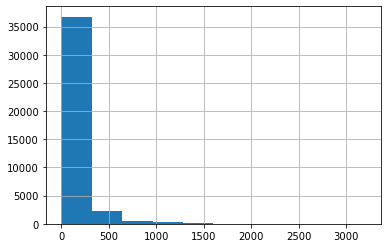

In [28]:
# В разнице дат есть выбросы.
df.diff_of_days.hist()
df.diff_of_days.describe()

75-й перцентиль: 120.0, IQR: 120.0,  Границы выбросов: [0, 300.0].


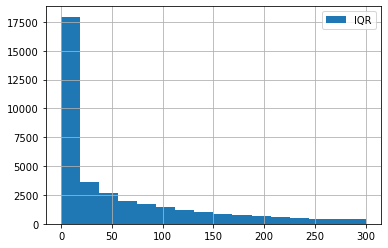

In [29]:
# Определим границу выбросов.
perc75 = df.diff_of_days.quantile(0.75)
IQR = df.diff_of_days.quantile(0.75)

print(
'75-й перцентиль: {},'.format(perc75),
"IQR: {}, ".format(IQR),
"Границы выбросов: [{f}, {l}].".format(f = 0, l=perc75 + 1.5*IQR))
 
df.diff_of_days.loc[df.diff_of_days.between(0, perc75 + 1.5*IQR)].hist(bins = 16, label = 'IQR')
 
plt.legend()

In [30]:
# Создадим новый признак по границе выбросов.

temp_list = df['diff_of_days'].tolist()

temp_days = []
for numb in temp_list:
    if numb in range(301,3300):
        temp_days.append(300)
    else:
        temp_days.append(numb)

df['diff_clear'] = temp_days

In [31]:
# Сделаем грубую нормализацию времени между отзывами по принципу: 1-100 дней - 2, 101-200 - 1, 0 и > 200 - 0.
diff_list = df['diff_of_days'].tolist()

norm_list = []
for numb in diff_list:
    if numb in range(1,101):
        norm_list.append(2)
    elif numb in range(101,201):
        norm_list.append(1)
    else:
        norm_list.append(0)
        
df['norm_of_days'] = norm_list
df['norm_of_days'].value_counts()

0    17669
2    17094
1     5237
Name: norm_of_days, dtype: int64

In [41]:
# Сделаем столбцы с датами.
date_one = []                                 # Список с первыми датами.
for date in dates_full:
    date = date[:1]         
    date_one.append(date)
    
date_str_one = str(date_one)                  # Почистим от лишнего в формате строки.
date_str_one = date_str_one.replace("[","")
date_str_one = date_str_one.replace("]","") 
date_str_one = date_str_one.replace("'","") 
date_str_one = date_str_one.replace(" ","")
date_str_one = date_str_one.replace('"',"")

delimiter = ','
date_one_list = date_str_one.split(delimiter) # Вернем список.

df['date_feedback_one'] = date_one_list
df['date_feedback_one'] = [datetime.strptime(x,'%m/%d/%Y') for x in date_one_list] # Столбец в формате datetime.

date_two = []                                 # Список со вторыми датами (признаки удалены, нет хорошего влияния)
for date in dates_full:
    date = date[1:]         
    date_two.append(date)
    
date_str_two = str(date_two)
date_str_two = date_str_two.replace("[","")
date_str_two = date_str_two.replace("]","") 
date_str_two = date_str_two.replace("'","") 
date_str_two = date_str_two.replace(" ","")
date_str_two = date_str_two.replace('"',"")
    
date_two_list = date_str_two.split(delimiter)

df['date_feedback_two'] = date_two_list
df['date_feedback_two'] = [datetime.strptime(x,'%m/%d/%Y') for x in date_two_list]

In [33]:
# Очистим из столбцов с датами произвольно записанные.
df.loc[df['date_feedback_one'] == '2021-01-01', 'date_feedback_one'] = np.nan
df.loc[df['date_feedback_two'] == '2021-01-01', 'date_feedback_two'] = np.nan

In [34]:
# Сделаем признак по месяцу первого отзыва.
df['month_one'] = df['date_feedback_one'].dt.strftime('%B')

In [35]:
# Заполним пропуски самым распространенным месяцем отзыва.
df['month_one'].fillna('December', inplace = True)

In [36]:
# Создадим признак - день недели по первой дате.
df['dayofweek_one'] = df['date_feedback_one'].dt.strftime('%A')

In [37]:
# Заполним день недели самым распространенным значением.
df['dayofweek_one'].fillna('Sunday', inplace = True)

In [38]:
# Создадим признаки по месяцам для первой даты.
month_one = set(df['month_one'].tolist())

for item in month_one:
    df[item] = df['month_one'].apply(find_item)

In [39]:
# Создадим признаки по дням недели для первой даты.
dayofweek_one = set(df['dayofweek_one'].tolist())

for item in dayofweek_one:
    df[item] = df['dayofweek_one'].apply(find_item)

# Посмотрим корреляцию переменных

In [40]:
df.corr()

,ranking,rating,price_range,number_of_reviews,rank_city_min,rank_city_max,rank_norm,price_NaN,number_of_reviews_NaN,NaN_cuisine_style,count_cuisine,vegetarian,asian_cuisine,Vienna,Madrid,Hamburg,Paris,Lyon,Zurich,Krakow,Oporto,Stockholm,Rome,Warsaw,Geneva,Copenhagen,Helsinki,Luxembourg,Berlin,Lisbon,Edinburgh,London,Bratislava,Barcelona,Ljubljana,Munich,Oslo,Prague,Athens,Amsterdam,Brussels,Milan,Dublin,Budapest,capital,numb_of_rest_city,population,population_density,diff_of_days,diff_clear,norm_of_days,January,September,March,June,August,April,December,October,November,July,May,February,Tuesday,Wednesday,Friday,Sunday,Saturday,Thursday,Monday
ranking,1.000000,-0.368371,-0.026525,-0.222072,-0.097652,0.709194,0.572562,0.233043,0.094078,0.147995,-0.320250,-0.145891,0.050962,-0.092039,0.055754,-0.097555,0.328009,-0.096448,-0.091098,-0.087357,-0.090281,-0.094931,-0.043718,-0.095860,-0.088282,-0.094270,-0.081664,-0.065863,-0.026367,-0.088900,-0.092951,0.499991,-0.075669,0.017390,-0.062811,-0.093938,-0.082608,-0.083389,-0.095177,-0.094372,-0.095232,-0.036981,-0.094965,-0.095534,0.202251,0.709115,0.568819,0.325374,0.065661,0.060447,-0.188682,-0.131497,0.009225,0.030604,0.023712,0.016616,0.041010,0.032534,-0.008117,-0.013225,0.023158,0.032599,-0.011658,-0.019896,-0.021044,-0.011376,0.074697,-0.017650,-0.014135,-0.020451
rating,-0.368371,1.000000,-0.028588,0.026924,0.015934,-0.061097,-0.544628,-0.064567,0.008386,-0.038263,0.120059,0.085177,-0.026374,0.022037,-0.083462,0.006539,-0.028288,-0.010079,0.008197,0.024333,0.031603,-0.026604,0.083082,0.019617,-0.005027,-0.001443,-0.006737,-0.008559,0.046967,0.014565,0.017489,-0.023273,-0.002988,-0.012890,0.012068,0.012207,-0.014680,0.011442,0.044792,0.034535,-0.020753,-0.059704,0.013431,0.020950,0.020758,-0.061376,-0.023410,-0.051684,-0.065990,-0.080198,0.065324,0.071076,-0.012662,-0.026803,-0.018472,-0.025287,-0.018953,0.012779,-0.007250,0.009368,-0.019662,-0.023197,0.005087,0.006285,0.000384,0.005452,-0.027300,0.004854,0.016429,0.005400
price_range,-0.026525,-0.028588,1.000000,0.107162,0.009486,0.006264,-0.047487,0.209937,0.040268,0.158268,0.003177,0.149918,-0.044182,0.013234,0.025759,0.022286,0.045851,0.022199,0.026925,-0.029583,-0.026726,0.031190,-0.054426,0.002334,0.040465,0.017700,0.002855,0.019274,-0.005090,-0.025470,-0.034082,-0.018934,0.009290,-0.013883,-0.005081,0.023440,0.019273,-0.019972,-0.020393,-0.000058,0.011326,-0.020068,-0.015349,-0.026396,-0.008270,0.006220,-0.018676,0.044047,-0.039184,-0.065504,-0.019514,0.034658,-0.018964,-0.016361,-0.017752,-0.027228,-0.014048,0.072407,-0.017759,-0.019509,-0.024221,-0.020490,-0.015206,-0.011874,-0.009566,-0.009304,0.056896,-0.011742,-0.022922,-0.014829
number_of_reviews,-0.222072,0.026924,0.107162,1.000000,-0.026693,0.027643,-0.405935,-0.266797,-0.105853,-0.201311,0.405641,0.158403,-0.016895,-0.024217,-0.023252,-0.040165,-0.002907,-0.018311,-0.017892,-0.001451,0.003872,-0.022549,0.133542,-0.027845,-0.022664,-0.014015,-0.020438,-0.010055,-0.046995,0.000857,0.046421,0.018121,-0.021603,0.006194,-0.011259,-0.021808,-0.009129,-0.004504,-0.010741,0.013348,-0.019411,0.039952,0.014049,0.014622,0.013466,0.027806,0.023448,-0.008964,-0.086586,-0.100689,0.268739,0.280881,-0.035056,-0.042132,-0.042517,-0.045180,-0.042942,-0.059250,-0.013649,0.008052,-0.046978,-0.043780,0.008829,0.037265,0.011893,0.011641,-0.099074,0.022790,0.010171,0.044707
rank_city_min,-0.097652,0.015934,0.009486,-0.026693,1.000000,-0.138265,0.001743,-0.018122,0.002627,-0.011219,-0.015187,-0.037168,-0.005520,-0.121715,-0.203880,-0.109501,0.213725,-0.106084,-0.007601,-0.074334,0.137865,-0.101619,-0.164428,-0.095570,0.203753,0.074060,0.179908,-0.004730,-0.015535,-0.128741,-0.086388,-0.288013,0.049826,0.500239,0.038793,0.086469,-0.069247,-0.012594,0.313740,-0.117344,0.094410,-0.166711,0.491717,-0.101366,-0.230335,-0.135380,-0.343287,0.446159,0.018272,0.021239,0.016063,0.001050,0.011265,0.004992,0.005248,0.005082,0.004542,-0.038816,0.010074,0.008225,0.010166,0.008052,0.005603,0.011466,0.

In [42]:
# rank_city_max сильно коррелирует с ranking. diff_of_days тоже уберем (почти diff_clear).

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 80 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   restaurant_id          40000 non-null  object        
 1   city                   40000 non-null  object        
 2   cuisine_style          40000 non-null  object        
 3   ranking                40000 non-null  float64       
 4   rating                 40000 non-null  float64       
 5   price_range            40000 non-null  float64       
 6   number_of_reviews      40000 non-null  float64       
 7   reviews                40000 non-null  object        
 8   url_ta                 40000 non-null  object        
 9   id_ta                  40000 non-null  object        
 10  rank_city_min          40000 non-null  float64       
 11  rank_city_max          40000 non-null  float64       
 12  rank_norm              40000 non-null  float64       
 13  p

In [43]:
df.drop(df.columns[[1,2,7,8,9,11,54,57,58,59,60]], axis = 1, inplace = True)
df.head(15)

,restaurant_id,ranking,rating,price_range,number_of_reviews,rank_city_min,rank_norm,price_NaN,number_of_reviews_NaN,NaN_cuisine_style,count_cuisine,vegetarian,asian_cuisine,Vienna,Madrid,Hamburg,Paris,Lyon,Zurich,Krakow,Oporto,Stockholm,Rome,Warsaw,Geneva,Copenhagen,Helsinki,Luxembourg,Berlin,Lisbon,Edinburgh,London,Bratislava,Barcelona,Ljubljana,Munich,Oslo,Prague,Athens,Amsterdam,Brussels,Milan,Dublin,Budapest,capital,numb_of_rest_city,population,population_density,diff_clear,norm_of_days,January,September,March,June,August,April,December,October,November,July,May,February,Tuesday,Wednesday,Friday,Sunday,Saturday,Thursday,Monday
0,id_5569,5570.0,3.5,1.0,194.0,3.0,0.398126,0,0,0.0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4897,2.148327,2.0781,41,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,id_1535,1537.0,4.0,1.0,10.0,1.0,0.623630,1,0,1.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,820,0.961609,0.5139,300,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,id_352,353.0,4.5,2.0,688.0,1.0,0.021407,0,0,0.0,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,5757,8.908081,0.5667,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,id_3456,3458.0,5.0,1.0,3.0,2.0,0.542543,1,0,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2155,3.644826,0.4463,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,id_615,621.0,4.0,1.0,84.0,3.0,0.223913,0,0,0.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,893,1.471508,0.4746,272,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
5,id_1418,1419.0,3.0,1.0,2.0,4.0,0.956081,1,0,1.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,513,0.237591,0.5703,108,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,id_1720,1722.0,4.0,0.0,50.0,1.0,0.274307,0,0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2133,1.372434,0.7582,93,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,id_825,826.0,3.0,1.0,9.0,3.0,0.928894,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,301,0.437725,0.1189,300,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
8,id_2690,2692.0,4.0,1.0,0.0,1.0,0.781586,1,1,1.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1166,1.888776,0.4502,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
9,id_4209,4210.0,4.0,0.0,55.0,1.0,0.707990,0,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2078,2.864466,0.2225,225,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [44]:
np.random.seed(12)
!pip freeze > requirements.txt

In [45]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['restaurant_id', 'rating'], axis = 1)  
y = df['rating']

In [46]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [47]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [48]:
def round_of_rating(number):
    """
    Округляем до 0.5
    """
    return np.round(number * 2) / 2

In [49]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [50]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = round_of_rating(regr.predict(X_test))

In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1754
